# Chapter 12: Discriminant Analysis

In [517]:
from pathlib import Path

import pandas as pd
import numpy as np
import math
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import matplotlib.pylab as plt

from dmba import classificationSummary
from dmba import gainsChart, liftChart

%matplotlib inline

In [518]:
# Working directory:
# replace the argument of the `Path`
DATA = Path('E:/Aliit/School/MSBA/206/MSBA-206/dmba')
# and then load data using 
# pd.read_csv(DATA / ‘filename.csv’)

## "Classification function" in Chapter 12 of the DMBA textbook is same as "disciminant function".

# Problem 12.1: Personal Loan Acceptance
Universal Bank is a relatively young bank growing
rapidly in terms of overall customer acquisition. The majority of
these customers are liability customers with varying sizes of
relationship with the bank. The customer base of asset customers is
quite small, and the bank is interested in expanding this base
rapidly to bring in more loan business. In particular, it wants to
explore ways of converting its liability customers to personal loan
customers.

A campaign the bank ran for liability customers last year showed a
healthy conversion rate of over 9\% successes. This has encouraged the
retail marketing department to devise smarter campaigns with better
target marketing. The goal of our analysis is to model the previous
campaign's customer behavior to analyze what combination of factors
make a customer more likely to accept a personal loan. This will serve
as the basis for the design of a new campaign.

The file _UniversalBank.csv_ contains data on 5000 customers. The data include customer demographic information (e.g., age, income), the customer's relationship with the bank (e.g., mortgage, securities account), and the customer response to the last personal loan campaign (Personal Loan). Among these 5000 customers, only 480 (= 9.6\%)
accepted the personal loan that was offered to them in the previous campaign.

Partition the data (60\% training and 40\% validation) and then perform a discriminant analysis that models Personal Loan as a function of the remaining predictors (excluding zip code). Remember to turn categorical predictors with more than two categories into dummy variables first. Specify the success class as 1 (personal loan acceptance), and use the default cutoff value of 0.5.



In [519]:
# Loading data, setting ID as index, and dropping ZIP Code
df_bank = pd.read_csv(DATA / 'UniversalBank.csv', index_col='ID').drop(columns='ZIP Code')

In [520]:
#Removing spaces from column names
names = df_bank.columns.to_list()
for x in names:
    df_bank = df_bank.rename(columns={x:x.replace(' ','_')})

In [521]:
df_bank

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
ID,,,,,,,,,,,,
1,25,1,49,4,1.6,1,0,0,1,0,0,0
2,45,19,34,3,1.5,1,0,0,1,0,0,0
3,39,15,11,1,1.0,1,0,0,0,0,0,0
4,35,9,100,1,2.7,2,0,0,0,0,0,0
5,35,8,45,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4996,29,3,40,1,1.9,3,0,0,0,0,1,0
4997,30,4,15,4,0.4,1,85,0,0,0,1,0
4998,63,39,24,2,0.3,3,0,0,0,0,0,0


In [522]:
catagoric = ['Family','Education']
for x in catagoric:
    df_bank[x] = df_bank[x].astype('category')

In [523]:
df_bank_dum = pd.get_dummies(data=df_bank,drop_first=False,dtype='int64')

In [524]:
catagoric = ['Family_1','Family_2','Family_3','Family_4','Education_1','Education_2','Education_3','Securities_Account','CD_Account', 'Online','CreditCard','Personal_Loan']
for x in catagoric:
    df_bank_dum[x] = df_bank_dum[x].astype('uint8')

In [525]:
outcome = 'Personal_Loan'
predictors = df_bank_dum.drop(columns=outcome).columns.to_list()

In [526]:
X = df_bank_dum[predictors]
y = df_bank_dum[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [527]:
da_reg = LinearDiscriminantAnalysis()#priors=[0.5,0.5])
da_reg.fit(train_X,train_y)

LinearDiscriminantAnalysis()

In [528]:
da_reg.priors_

array([0.90433333, 0.09566667])

## Problem 12.1.a
Compute summary statistics for the predictors separately for loan acceptors and nonacceptors. For continuous predictors, compute the mean and standard deviation. For categorical predictors, compute the percentages. Are there predictors where the two classes differ substantially?

In [529]:
acceptors = train_X[train_y == 1]
non_acceptors = train_X[train_y == 0]

for x in train_X.columns:
    if train_X[x].dtype == 'uint8':
        # Categorical variable
        acceptor_pct = acceptors[x].sum() / len(acceptors)
        non_acceptor_pct = non_acceptors[x].sum() / len(non_acceptors)
        print(f'{x}: acceptors {acceptor_pct:.2%}, non-acceptors {non_acceptor_pct:.2%}')
    else:
        # Continuous variable
        acceptor_mean = acceptors[x].mean()
        acceptor_std = acceptors[x].std()
        non_acceptor_mean = non_acceptors[x].mean()
        non_acceptor_std = non_acceptors[x].std()
        print(f'{x}: acceptors {acceptor_mean:.2f}±{acceptor_std:.2f}, non-acceptors {non_acceptor_mean:.2f}±{non_acceptor_std:.2f}')

Age: acceptors 44.53±11.37, non-acceptors 45.69±11.48
Experience: acceptors 19.34±11.32, non-acceptors 20.45±11.49
Income: acceptors 145.47±31.31, non-acceptors 66.18±40.86
CCAvg: acceptors 4.06±2.00, non-acceptors 1.71±1.55
Mortgage: acceptors 98.46±160.58, non-acceptors 52.06±91.46
Securities_Account: acceptors 12.89%, non-acceptors 9.92%
CD_Account: acceptors 31.01%, non-acceptors 3.35%
Online: acceptors 60.98%, non-acceptors 58.75%
CreditCard: acceptors 30.66%, non-acceptors 29.64%
Family_1: acceptors 19.86%, non-acceptors 30.00%
Family_2: acceptors 24.04%, non-acceptors 26.35%
Family_3: acceptors 29.27%, non-acceptors 19.35%
Family_4: acceptors 26.83%, non-acceptors 24.29%
Education_1: acceptors 18.47%, non-acceptors 43.72%
Education_2: acceptors 40.42%, non-acceptors 27.02%
Education_3: acceptors 41.11%, non-acceptors 29.27%


In [530]:
classificationSummary(train_y,da_reg.predict(train_X),class_names=['Not Accepted','Accepted'])

Confusion Matrix (Accuracy 0.9460)

             Prediction
      Actual Not Accepted     Accepted
Not Accepted         2659           54
    Accepted          108          179


## Problem 12.1.b
Examine the model performance on the validation set.
## Problem 12.1.b.i
What is the accuracy rate?

In [531]:
classificationSummary(valid_y,da_reg.predict(valid_X),class_names=['Not Accepted','Accepted'])

Confusion Matrix (Accuracy 0.9430)

             Prediction
      Actual Not Accepted     Accepted
Not Accepted         1776           31
    Accepted           83          110


In [532]:
valid_sum = pd.DataFrame(valid_X)
valid_sum['Actual'] = valid_y
valid_sum['Prediction'] = da_reg.predict(valid_X)
valid_sum['p(Accept)'] = da_reg.predict_proba(valid_X)[:,1]
valid_sum

,Age,Experience,Income,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Family_1,Family_2,Family_3,Family_4,Education_1,Education_2,Education_3,Actual,Prediction,p(Accept)
ID,,,,,,,,,,,,,,,,,,,
2765,31,5,84,2.9,105,0,0,0,1,1,0,0,0,0,0,1,0,0,0.010951
4768,35,9,45,0.9,101,1,0,0,0,0,0,1,0,1,0,0,0,0,0.000083
3815,34,9,35,1.3,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0.000205
3500,49,23,114,0.3,286,0,0,1,0,1,0,0,0,1,0,0,0,0,0.001994
2736,36,12,70,2.6,165,0,0,1,0,0,0,1,0,0,1,0,0,0,0.033432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4373,34,10,41,2.4,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.001699
3402,39,15,28,1.4,118,0,0,1,1,1,0,0,0,0,0,1,0,0,0.000235
1240,51,26,12,0.7,109,0,0,1,1,0,1,0,0,0,0,1,0,0,0.000068


## Problem 12.1.b.ii
Is one type of misclassification more likely than the other?

In [533]:
valid_sum.Actual.value_counts()

Actual
0    1807
1     193
Name: count, dtype: int64

In [534]:
valid_sum.Prediction.value_counts()

Prediction
0    1859
1     141
Name: count, dtype: int64

In [535]:
actual_A = round((193/(1807+193))*100,4)
actual_NA = round((1807/(1807+193))*100,4)
print(actual_A)
print(actual_NA)

9.65
90.35


In [536]:
pred_A = round((289/(1711+289))*100,4)
pred_NA = round((1711/(1711+289))*100,4)
print(pred_A)
print(pred_NA)

14.45
85.55


In [537]:
diff_A = pred_A-actual_A
diff_NA = pred_NA-actual_NA
print(diff_A)
print(diff_NA)

4.799999999999999
-4.799999999999997


#### It is much more likely to miss classify as an acceptor more than as a non acceptor.

## Problem 12.1.b.iii
Select three customers who were misclassified as _acceptors_ and three who were misclassified as _nonacceptors_. The goal is to determine why they are misclassified. First, examine their probability of being classified as acceptors: is it close to the
threshold of 0.5? If not, compare their predictor values to the summary statistics of the two classes to determine why they were misclassified.

In [538]:
bads_id = []
bads = valid_sum[['Actual','Prediction']].where(valid_sum.Actual != valid_sum.Prediction).dropna()
for x in bads.sort_values(ascending=False,by='Actual').head(3).index:
    bads_id.append(x)
for x in bads.sort_values(ascending=True,by='Actual').head(3).index:
    bads_id.append(x)
bads = valid_sum.query('index in @bads_id')
bads

,Age,Experience,Income,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Family_1,Family_2,Family_3,Family_4,Education_1,Education_2,Education_3,Actual,Prediction,p(Accept)
ID,,,,,,,,,,,,,,,,,,,
933,51,27,112,1.80,0,1,1,1,1,0,0,1,0,0,1,0,0,1,0.942790
2935,37,13,195,6.50,635,0,0,1,0,0,1,0,0,1,0,0,0,1,0.812228
3759,47,23,199,6.67,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0.692554
3836,33,9,131,2.20,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0.278608
4703,35,5,108,2.75,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0.010977
2305,27,2,170,4.70,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0.445307


In [539]:
acceptors = train_X[train_y == 1]
non_acceptors = train_X[train_y == 0]

for x in train_X.columns:
    if train_X[x].dtype == 'uint8':
        # Categorical variable
        acceptor_pct = acceptors[x].sum() / len(acceptors)
        non_acceptor_pct = non_acceptors[x].sum() / len(non_acceptors)
        print(f'{x}: acceptors {acceptor_pct:.2%}, non-acceptors {non_acceptor_pct:.2%}')
    else:
        # Continuous variable
        acceptor_mean = acceptors[x].mean()
        acceptor_std = acceptors[x].std()
        non_acceptor_mean = non_acceptors[x].mean()
        non_acceptor_std = non_acceptors[x].std()
        print(f'{x}: acceptors {acceptor_mean:.2f}±{acceptor_std:.2f}, non-acceptors {non_acceptor_mean:.2f}±{non_acceptor_std:.2f}')

Age: acceptors 44.53±11.37, non-acceptors 45.69±11.48
Experience: acceptors 19.34±11.32, non-acceptors 20.45±11.49
Income: acceptors 145.47±31.31, non-acceptors 66.18±40.86
CCAvg: acceptors 4.06±2.00, non-acceptors 1.71±1.55
Mortgage: acceptors 98.46±160.58, non-acceptors 52.06±91.46
Securities_Account: acceptors 12.89%, non-acceptors 9.92%
CD_Account: acceptors 31.01%, non-acceptors 3.35%
Online: acceptors 60.98%, non-acceptors 58.75%
CreditCard: acceptors 30.66%, non-acceptors 29.64%
Family_1: acceptors 19.86%, non-acceptors 30.00%
Family_2: acceptors 24.04%, non-acceptors 26.35%
Family_3: acceptors 29.27%, non-acceptors 19.35%
Family_4: acceptors 26.83%, non-acceptors 24.29%
Education_1: acceptors 18.47%, non-acceptors 43.72%
Education_2: acceptors 40.42%, non-acceptors 27.02%
Education_3: acceptors 41.11%, non-acceptors 29.27%


#### None of them are close to the threshold of 0.50. Far as I can tell, it may be from a lot of the values from my selected "bads" are outside the std of their predictors. For ID 933, We see its the only one with a CD_Account and Securities_Account, which pushed it well into the prediction range of being an acceptor, while in reality it was a denier. They may just be an outlier.

## Problem 12.1.c
As in many marketing campaigns, it is more important to identify customers who will accept the offer rather than customers who will not accept it. Therefore, a good model should be especially accurate at detecting acceptors. Examine the lift chart and decile-wise lift chart for the validation set and interpret them in light of this ranking goal.

<function matplotlib.pyplot.show(close=None, block=None)>

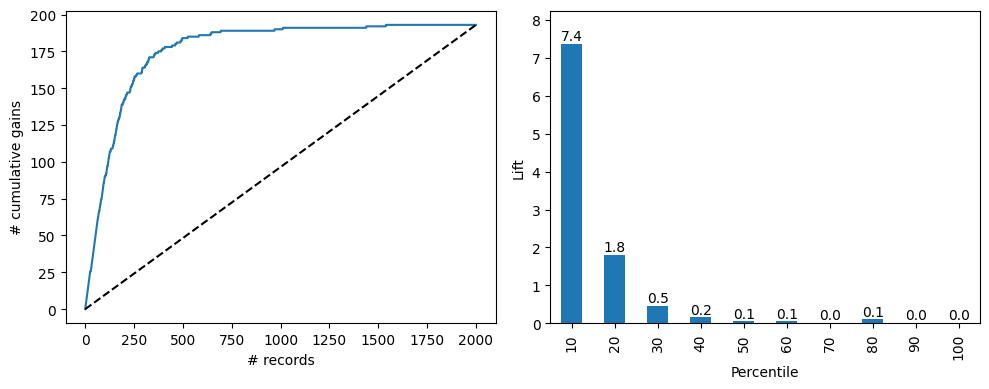

In [540]:
valid_sum = valid_sum.sort_values(by=['p(Accept)'], ascending=False)
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,4))
gainsChart(valid_sum.Actual, ax=axes[0])
liftChart(valid_sum.Actual,title=False, ax=axes[1])
plt.tight_layout()
plt.show

#### Looking at the charts, we can see that overall the model improves the gains by 7.4 times for the first decile. unfortunately due to its rather high rate of misclassifying the acceptors as non acceptors, this information must be scrutinized further, likely by improving the priors used.

## Problem 12.1.d
Compare the results from the discriminant analysis with those from a logistic regression (both with cutoff 0.5 and the same predictors). Examine the confusion matrices, the lift charts, and the decile charts. Which method performs better on your validation set in detecting the acceptors?

We can take the confusion matrix from the logistic regression model in chapter 10.
```
Confusion Matrix (Accuracy 0.9595)

       Prediction
Actual    0    1
     0 1791   16
     1   65  128
```

Confusion Matrix (Accuracy 0.9615)

             Prediction
      Actual Not Accepted     Accepted
Not Accepted         1794           13
    Accepted           64          129


<function matplotlib.pyplot.show(close=None, block=None)>

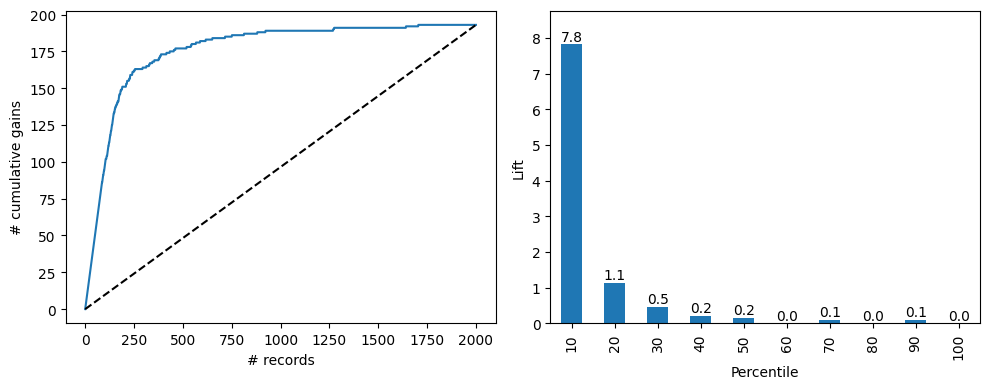

In [541]:
lg_reg = LogisticRegression(max_iter=10000,penalty="l2", C=1e42, solver='liblinear', tol=1e-8)
lg_reg.fit(train_X, train_y)
classificationSummary(valid_y,lg_reg.predict(valid_X),class_names=['Not Accepted','Accepted'])
lg_proba = lg_reg.predict_proba(valid_X)
result = pd.DataFrame({'Actual':valid_y,
                      'p(0)': [p[0] for p in lg_proba],
                      'p(1)': [p[1] for p in lg_proba]
                      })
df = result.sort_values(by=['p(1)'], ascending=False)

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,4))
gainsChart(df.Actual, ax=axes[0])
liftChart(df.Actual,title=False, ax=axes[1])
plt.tight_layout()
plt.show

Confusion Matrix (Accuracy 0.9430)

             Prediction
      Actual Not Accepted     Accepted
Not Accepted         1776           31
    Accepted           83          110


<function matplotlib.pyplot.show(close=None, block=None)>

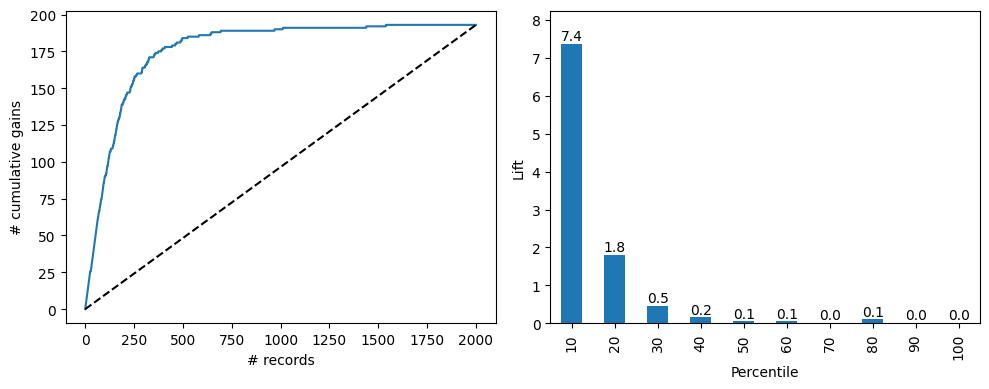

In [542]:
classificationSummary(valid_y,da_reg.predict(valid_X),class_names=['Not Accepted','Accepted'])
valid_sum = valid_sum.sort_values(by=['p(Accept)'], ascending=False)
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,4))
gainsChart(valid_sum.Actual, ax=axes[0])
liftChart(valid_sum.Actual,title=False, ax=axes[1])
plt.tight_layout()
plt.show

#### Comparing Logistic Regression and Discriminant Analysis, it would appear that Discriminant Analysis did a better job. Taking the cumulative gains in the decile lift chart the DA performs .2 better.

## Problem 12.1.e
The bank is planning to continue its campaign by sending its offer to 1000 additional customers. Suppose that the cost of sending the offer is \\$1 and the profit from an accepted offer is \\$50. What is the expected profitability of this campaign?


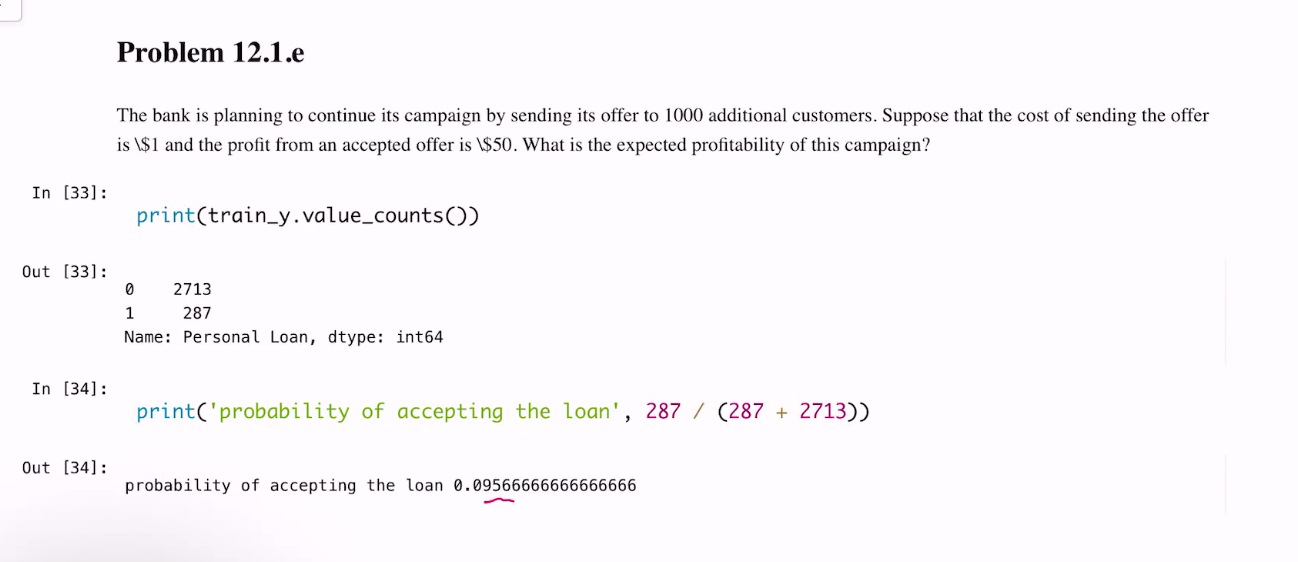

In [543]:
train_y.value_counts()[1]

287

In [544]:
prob_accept = train_y.value_counts()[1]/(train_y.value_counts()[1]+train_y.value_counts()[0])
prob_accept

0.09566666666666666

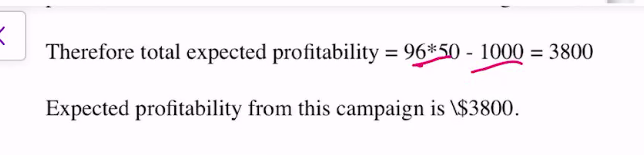

In [545]:
model = round(0.9430*100,2)
misclass_cost = 50
target_count = 1000

In [546]:
profitability = round(model*misclass_cost-target_count)
print(profitability)

3715


#### Based on my numbers, the profit of this campaign should be $32241. This is because you take the number of offers sent out, multiply it by the probability of saying yes per my model and then the models accuracy and finally subtract the costs from the predicted profit, multiplied by -1 to make it positive in this case.

## Problem 12.1.f
The cost of misclassifying a loan acceptor customer as a nonacceptor is much higher than the opposite misclassification cost. To minimize the expected cost of misclassification, should the cutoff value for classification (which is currently at 0.5) be increased or decreased?

#### Given that the cost of misclassifying a record as accepting the offer when they will not costs 1/50 of correctly accepting the offer, I think we should decrease the cutoff value, as catching the outliers will net more profit, so long as the number of not-accepts is less than 48 per accept.
#### In my Validation set there are 193 Accepts. This means if we keep the number of false accepted under 4632, our profit still stays significantly high.
#### If my profitability formula is correct, then our best bet is to set priors to 0.016,0.984 and run the model. This nets in a crazy drop in accuracy, but improves profitability.
#### If we focus on model accuracy, were better with 0.805,0.195. Its much lower profit, but is also the safer bet as it errs on the side of caution.

In [547]:
from sklearn.metrics import confusion_matrix

In [551]:
#Created a bit of a CV here to test priors.
results = pd.DataFrame(columns=['Accuracy','Priors','Predicted','Profit','Actual_Yes_As_No'])
#Accuracy = max_acc
#Priors = z
#Predicted = pred_A
#Profit = profitability
tester = range(1,1000)
max_acc = 0
misclass_cost = 50
target_count = 1000
for x in tester:
    z = x/1000
    #testing if using the default priors has a significant change (hint it does!)
    da_reg = LinearDiscriminantAnalysis(priors=[z,1-z])
    da_reg.fit(train_X,train_y)
    valid_sum = pd.DataFrame(valid_X)
    valid_sum['Actual'] = valid_y
    valid_sum['Prediction'] = da_reg.predict(valid_X)
    valid_sum['p(Accept)'] = da_reg.predict_proba(valid_X)[:,1]
    cf = confusion_matrix(valid_sum.Actual,valid_sum.Prediction)
    ANA_PNA =cf[0][0]
    ANA_PA =cf[0][1]
    AA_PNA =cf[1][0]
    AA_PA =cf[1][1]
    TOTAL = cf[0][0]+cf[0][1]+cf[1][0]+cf[1][1]
    bank_acc = (ANA_PNA+AA_PA)/TOTAL
    if bank_acc > max_acc:
        max_acc = bank_acc
    Predict_NA = ANA_PNA+AA_PNA
    Predict_A = ANA_PA+AA_PA
    pred_A = round((Predict_A/(Predict_NA+Predict_A)),5)
    model = round(bank_acc*100,2)
    profitability = round(model*misclass_cost-target_count)
    actual_yes = cf[1][0]
    results.loc[len(results.index)] = [bank_acc,z,pred_A,profitability,actual_yes]

results = results.sort_values(by=['Profit'], ascending=False)
print(max_acc)
results#.head(1)

0.949


,Accuracy,Priors,Predicted,Profit,Actual_Yes_As_No
804,0.9490,0.805,0.0935,3745.0,54.0
803,0.9490,0.804,0.0935,3745.0,54.0
802,0.9490,0.803,0.0935,3745.0,54.0
806,0.9485,0.807,0.0930,3742.0,55.0
805,0.9485,0.806,0.0930,3742.0,55.0
...,...,...,...,...,...
4,0.3905,0.005,0.7040,952.0,2.0
3,0.3630,0.004,0.7325,815.0,1.0
2,0.3290,0.003,0.7665,645.0,1.0
1,0.2935,0.002,0.8030,468.0,0.0


In [510]:
#testing if using the default priors has a significant change (hint it does!)
da_reg = LinearDiscriminantAnalysis(priors=[0.805,0.195])
da_reg.fit(train_X,train_y)
classificationSummary(valid_y,da_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9490)

       Prediction
Actual    0    1
     0 1759   48
     1   54  139


In [511]:
valid_sum = pd.DataFrame(valid_X)
valid_sum['Actual'] = valid_y
valid_sum['Prediction'] = da_reg.predict(valid_X)
valid_sum['p(Accept)'] = da_reg.predict_proba(valid_X)[:,1]

In [512]:
Predict_NA = ANA_PNA+AA_PNA
Predict_A = ANA_PA+AA_PA

In [513]:
confusion_matrix(valid_sum.Actual,valid_sum.Prediction)

array([[1759,   48],
       [  54,  139]], dtype=int64)

In [516]:
cf[1][0]

54

In [515]:
cf = confusion_matrix(valid_sum.Actual,valid_sum.Prediction)
ANA_PNA =cf[0][0]
ANA_PA =cf[0][1]
AA_PNA =cf[1][0]
AA_PA =cf[1][1]
TOTAL = cf[0][0]+cf[0][1]+cf[1][0]+cf[1][1]
bank_acc = (ANA_PNA+AA_PA)/TOTAL
print(bank_acc)

0.949


In [456]:
pred_A = round((Predict_A/(Predict_NA+Predict_A)),5)
pred_NA = round((Predict_NA/(Predict_NA+Predict_A)),5)
print(pred_A)
print(pred_NA)

0.0155
0.9845


In [457]:
profitability = round(((1*1000)-(((1000*bank_acc)*pred_A)*50))*-1)
print(profitability)

-265


Confusion Matrix (Accuracy 0.9490)

             Prediction
      Actual Not Accepted     Accepted
Not Accepted         1759           48
    Accepted           54          139


<function matplotlib.pyplot.show(close=None, block=None)>

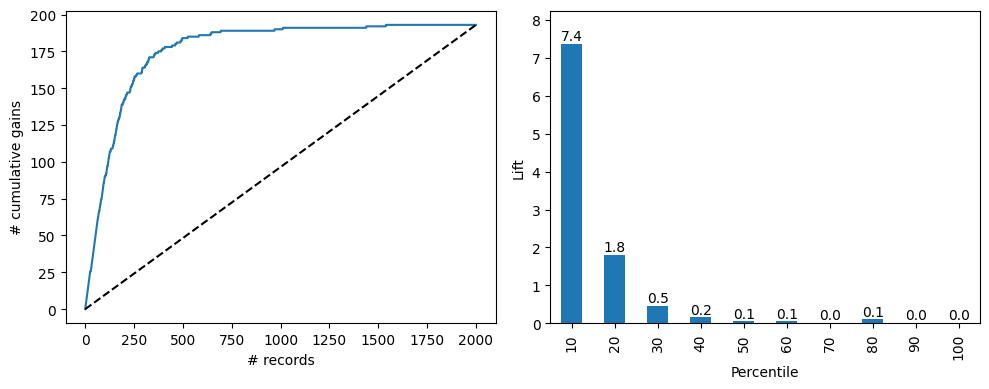

In [458]:
classificationSummary(valid_y,da_reg.predict(valid_X),class_names=['Not Accepted','Accepted'])
valid_sum = valid_sum.sort_values(by=['p(Accept)'], ascending=False)
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,4))
gainsChart(valid_sum.Actual, ax=axes[0])
liftChart(valid_sum.Actual,title=False, ax=axes[1])
plt.tight_layout()
plt.show

# Problem 12.3: Detecting Spam E-mail (from the UCI Machine Learning Repository)
A team at Hewlett-Packard collected data on a large number of e-mail messages from their postmaster and personal e-mail for the purpose of finding a classifier that can separate e-mail messages that are _spam_ vs. _nonspam_ (a.k.a. 'ham'). The spam concept is diverse: It includes advertisements for products or websites, 'make money fast' schemes, chain letters, pornography, and so on. The definition used here is 'unsolicited commercial e-mail.' The file _Spambase.csv_ contains information on 4601 e-mail messages, among which 1813 are tagged 'spam.' The predictors include 57 attributes, most of them are the average number of times a certain word (e.g., mail, George) or symbol (e.g., \#, !) appears in the e-mail. A few predictors are
related to the number and length of capitalized words.

## Problem 12.3.a
To reduce the number of predictors to a manageable size, examine how each predictor differs between the _spam_ and _nonspam_ e-mails by comparing the spam-class average and nonspam-class average. Which are the 11 predictors that appear to vary the most between _spam_ and _nonspam_ e-mails? From these 11, which words or signs occur more often in spam?

In [459]:
# Loading data, setting ID as index, and dropping ZIP Code
df_spam = pd.read_csv(DATA / 'Spambase.csv')#, index_col='ID').drop(columns='ZIP Code')

In [460]:
#Removing spaces from column names
names = df_spam.columns.to_list()
for x in names:
    df_spam = df_spam.rename(columns={x:x.replace(' ','_')})

In [461]:
df_spam['Spam'] = df_spam.Spam.replace(1,'spam')
df_spam['Spam'] = df_spam.Spam.replace(0,'not_spam')
df_spam['Spam'] = df_spam['Spam'].astype(dtype='category')

In [462]:
outcome = 'Spam'

In [463]:
spam = df_spam.where(df_spam.Spam == 'spam').dropna().drop(columns=outcome)
not_spam = df_spam.where(df_spam.Spam == 'not_spam').dropna().drop(columns=outcome)

In [464]:
spam_results = pd.DataFrame(columns=['mean_spam','mean_not_spam'])

In [465]:
spam_desc = spam.describe().T
spam_desc.rename(columns={'mean':'mean_spam'}, inplace=True)

In [466]:
not_spam_desc = not_spam.describe().T
not_spam_desc.rename(columns={'mean':'mean_not_spam'}, inplace=True)

In [467]:
spam_results['mean_spam'] = spam_desc['mean_spam']
spam_results['mean_not_spam'] = not_spam_desc['mean_not_spam']

In [468]:
spam_results['diff'] = abs(spam_results.mean_spam - spam_results.mean_not_spam)
spam_results = spam_results.sort_values(by='diff',ascending=False)
predictors = spam_results.head(11).T.columns.to_list()
print(predictors)

['CAP_tot', 'CAP_long', 'CAP_avg', 'george', 'you_', 'your', 'hp', 'free', 'hpl', 'C!', 'our']


#### Based on the outputted list above, we can see that Capital letters, words, and counts along with george, you_, your, hp, free, hpl, C!, and our are the most used words by %.

## Problem 12.3.b
Partition the data into training and validation sets, then perform a discriminant analysis on the training data using only the 11 predictors.

In [469]:
X = df_spam[predictors]
y = df_spam[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [470]:
lda_reg_1 = LinearDiscriminantAnalysis()#priors=[0.5,0.5])
lda_reg_1.fit(train_X,train_y)
print('Priors',lda_reg_1.priors_)
print('Coefficients', lda_reg_1.coef_)
print('Intercept', lda_reg_1.intercept_)

Priors [0.61231884 0.38768116]
Coefficients [[ 1.01505623e-03  4.17051777e-04  4.22902842e-03 -9.43539189e-02
   1.86853238e-01  5.81145106e-01 -1.85640249e-01  6.50457481e-01
  -3.16915182e-01  4.39462081e-01  6.75883468e-01]]
Intercept [-2.07053468]


## Problem 12.3.c
If we are interested mainly in detecting spam messages, is this model useful? Use the confusion matrix, lift chart, and decile chart for the validation set for the evaluation.

Confusion Matrix (Accuracy 0.8332)

         Prediction
  Actual not_spam     spam
not_spam     1030       68
    spam      239      504


<function matplotlib.pyplot.show(close=None, block=None)>

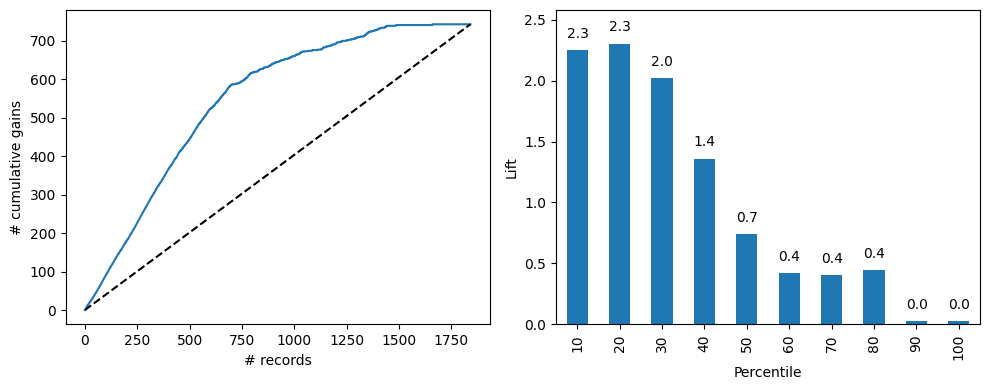

In [471]:
classificationSummary(valid_y,lda_reg_1.predict(valid_X),class_names=lda_reg_1.classes_)
lda_proba_1 = lda_reg_1.predict_proba(valid_X)
result_1 = pd.DataFrame({'Actual':valid_y,
                      'p(0)': [p[0] for p in lda_proba_1],
                      'p(1)': [p[1] for p in lda_proba_1]
                      })
result_1['Actual'] = result_1.Actual.replace('spam',1)
result_1['Actual'] = result_1.Actual.replace('not_spam',0)
result_1['Actual'] = result_1['Actual'].astype(dtype='uint8')
result_1 = result_1.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,4))
gainsChart(result_1.Actual, ax=axes[0])
liftChart(result_1.Actual,title=False, ax=axes[1])
plt.tight_layout()
plt.show


## Problem 12.3.d
In the sample, almost 40\% of the e-mail messages were tagged as spam. However, suppose that the actual proportion of spam messages in these e-mail accounts is 10\%. Compute the intercept of the classification (discriminant) function to account for this information.

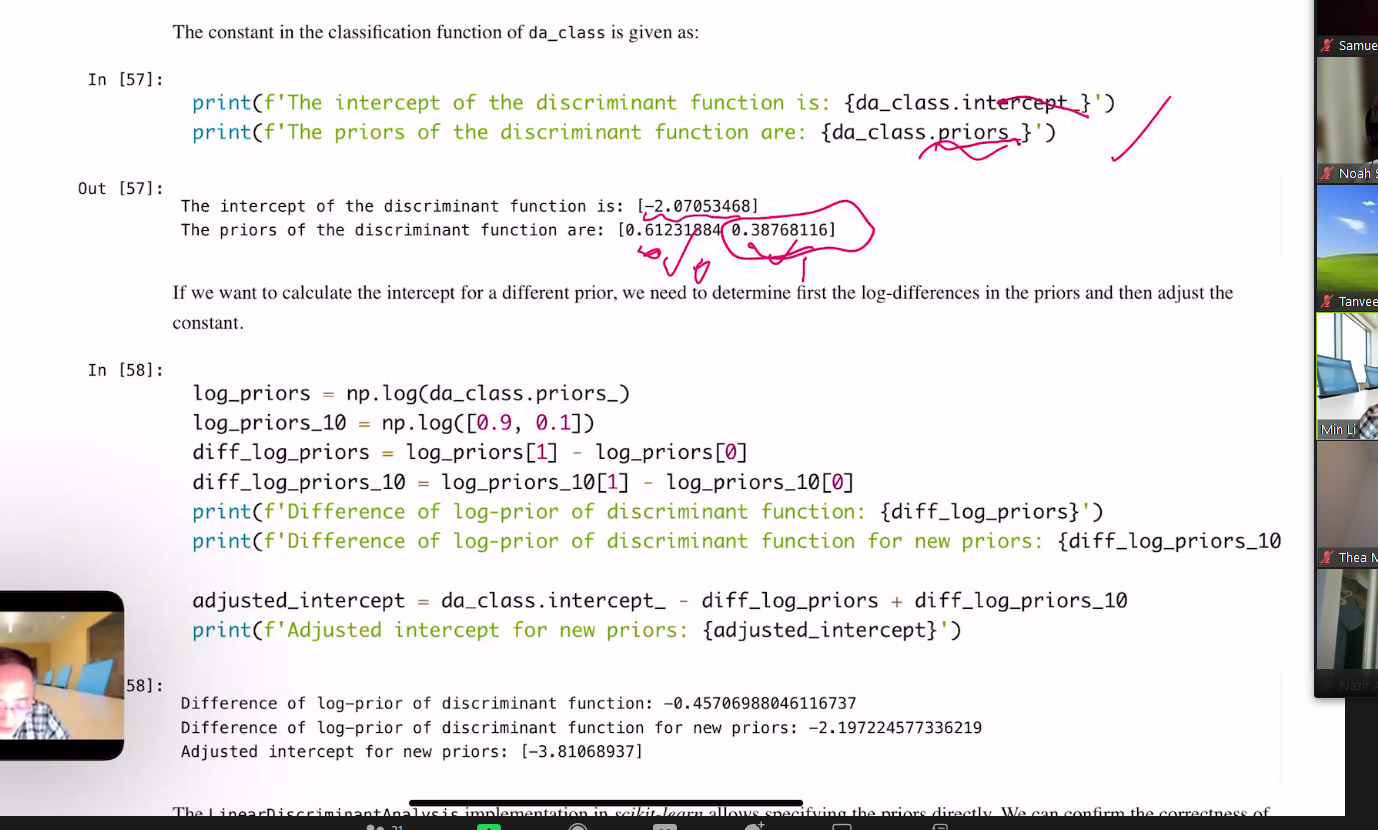

#### Or we can do this.

In [472]:
lda_reg_2 = LinearDiscriminantAnalysis(priors=[0.9,0.1])
lda_reg_2.fit(train_X,train_y)
print('Intercept', lda_reg_2.intercept_[0])

Intercept -3.810689374186764


Confusion Matrix (Accuracy 0.6594)

         Prediction
  Actual not_spam     spam
not_spam     1086       12
    spam      615      128


<function matplotlib.pyplot.show(close=None, block=None)>

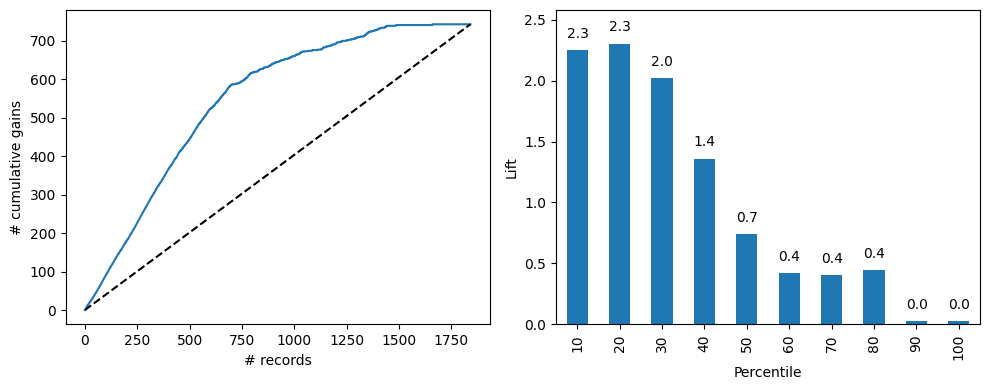

In [473]:
classificationSummary(valid_y,lda_reg_2.predict(valid_X),class_names=lda_reg_2.classes_)
lda_proba_2 = lda_reg_2.predict_proba(valid_X)
result_2 = pd.DataFrame({'Actual':valid_y,
                      'p(0)': [p[0] for p in lda_proba_2],
                      'p(1)': [p[1] for p in lda_proba_2]
                      })
result_2['Actual'] = result_2.Actual.replace('spam',1)
result_2['Actual'] = result_2.Actual.replace('not_spam',0)
result_2['Actual'] = result_2['Actual'].astype(dtype='uint8')
result_2 = result_2.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,4))
gainsChart(result_2.Actual, ax=axes[0])
liftChart(result_2.Actual,title=False, ax=axes[1])
plt.tight_layout()
plt.show

## Problem 12.3.e
A spam filter that is based on your model is used, so that only messages that are classified as _nonspam_ are delivered, while messages that are classified as _spam_ are quarantined. In this case, misclassifying a nonspam e-mail (as spam) has much heftier results. Suppose that the cost of quarantining a nonspam e-mail is 20 times
that of not detecting a spam message. Compute the intercept of the classification (discriminant) function to account for these costs (<b>assume that the proportion of spam is reflected correctly by the sample proportion</b>).

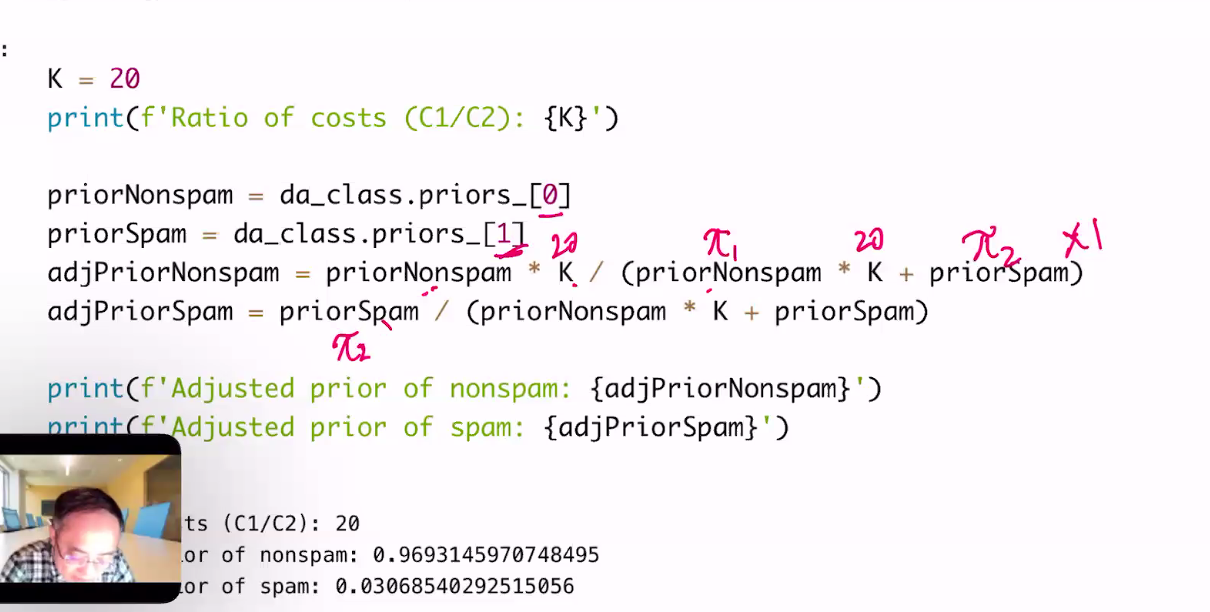

In [417]:
v = 20
p1 = 0.6
p2 = 0.4
c1 = 1
c2 = v/c1
prior1 = (p1*c1)/((p1*c1)+(p2*c2))
prior2 = (p2*c2)/((p1*c1)+(p2*c2))
print(v)
print(p1)
print(p2)
print(c1)
print(c2)
print(prior1)
print(prior2)
print(prior1+prior2)

20
0.6
0.4
1
20.0
0.06976744186046512
0.9302325581395349
1.0


In [474]:
lda_reg_3 = LinearDiscriminantAnalysis(priors=[prior2,prior1])
lda_reg_3.fit(train_X,train_y)
print('Intercept', lda_reg_3.intercept_[0])

Intercept -4.203731962296371


## Problem 12.3.f
Use the LinearDiscriminantAnalysis implementation in sklearn to adjust the priors to take the misclassification costs in 12.3.e into account. Does adjusting the priors to take the misclassification costs into account lead to a model which predicts fewer <i>nonspam</i> messages as <i>spam</i>? Report the numerical result.

Confusion Matrix (Accuracy 0.6372)

         Prediction
  Actual not_spam     spam
not_spam     1089        9
    spam      659       84


<function matplotlib.pyplot.show(close=None, block=None)>

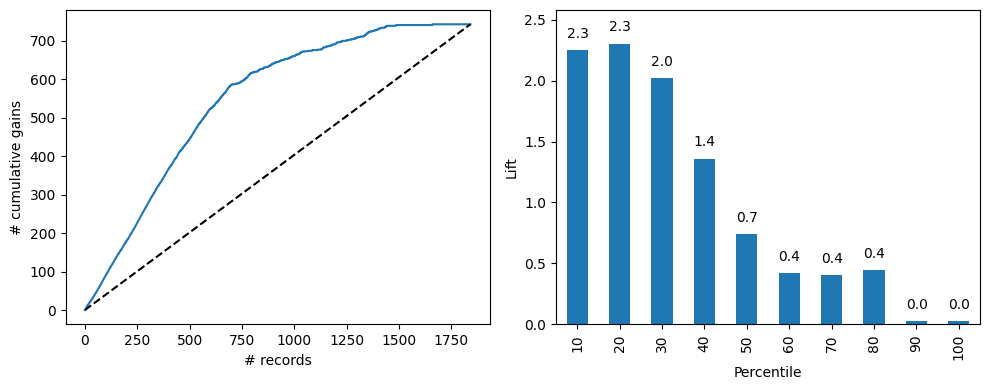

In [475]:
classificationSummary(valid_y,lda_reg_3.predict(valid_X),class_names=lda_reg_3.classes_)
lda_proba_3 = lda_reg_3.predict_proba(valid_X)
result_3 = pd.DataFrame({'Actual':valid_y,
                      'p(0)': [p[0] for p in lda_proba_3],
                      'p(1)': [p[1] for p in lda_proba_3]
                      })
result_3['Actual'] = result_3.Actual.replace('spam',1)
result_3['Actual'] = result_3.Actual.replace('not_spam',0)
result_3['Actual'] = result_3['Actual'].astype(dtype='uint8')
result_3 = result_3.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,4))
gainsChart(result_3.Actual, ax=axes[0])
liftChart(result_3.Actual,title=False, ax=axes[1])
plt.tight_layout()
plt.show

In [476]:
import scikitplot as skplt

<function matplotlib.pyplot.show(close=None, block=None)>

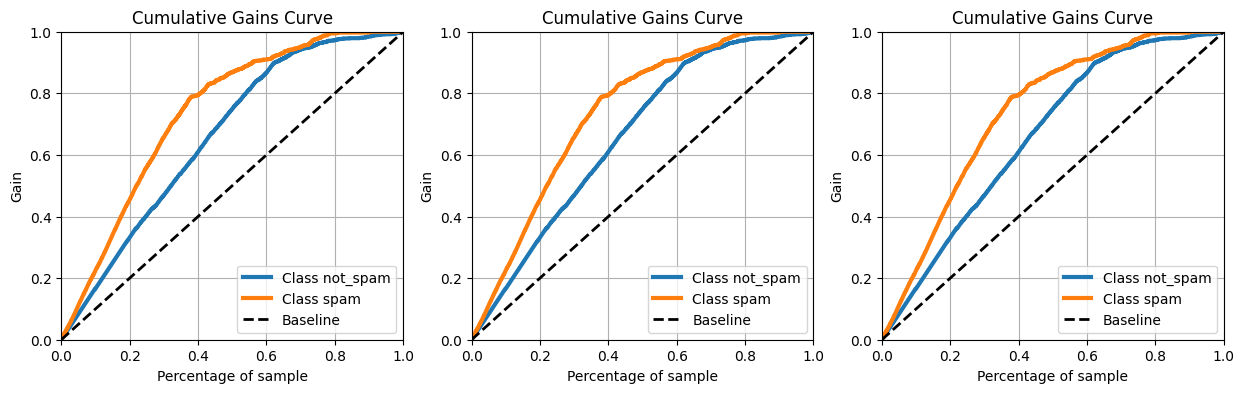

In [477]:
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(15,4))
skplt.metrics.plot_cumulative_gain(valid_y, lda_proba_1, ax=axes[0])
skplt.metrics.plot_cumulative_gain(valid_y, lda_proba_2, ax=axes[1])
skplt.metrics.plot_cumulative_gain(valid_y, lda_proba_3, ax=axes[2])
plt.show

#### Taking the misclassification costs into account results in lower accuracy and the same decile lift chart. Not sure if its actually improving this with this test set or not.